# Lab 9: Using Amazon SageMaker Pipelines and the SageMaker Model Registry with SageMaker Studio

In this lab you create and run an Amazon Sagemaker Pipeline and monitor the pipeline's progress. You also locate and explore some of the artifacts that the machine learning (ML) process uses or generates.

If time permits, you can also review the lineage details for the model that the pipeline generated.

### Task 2.1: Environment setup

Before you create your SageMaker Pipeline, you must prepare the environment by installing necessary packages, importing modules, and staging supporting files. This Sagemaker Pipeline was designed to use a feature group, so you also create a feature group in Amazon SageMaker Feature Store and run a Data Wrangler flow to prepare your environment. 

Run the cells in this task to do the following:
- Install dependencies.
- Import required modules.
- Copy data and code to Amazon Simple Storage Service (Amazon S3).
- Create a feature group.
- Ingest features into the feature group.

### Task 2.2: Install dependencies

In [1]:
%%capture
#install dependencies
%pip install --upgrade pip 
%pip install pytest-astropy ==  0.7.0
%pip install rsa == 4.7.2
%pip install PyYAML
!apt update && apt install -y git
%pip install git+https://github.com/aws-samples/ml-lineage-helper

### Task 2.3: Import modules

In [2]:
#import-modules
import os
import json
import boto3
import sagemaker
import sagemaker.session
import datetime as dt
import pandas as pd
import time
from time import gmtime, strftime
import uuid
from sagemaker.estimator import Estimator
from sagemaker.inputs import TrainingInput
from sagemaker.model_metrics import (
    MetricsSource,
    ModelMetrics,
)
from sagemaker.processing import (
    ProcessingInput,
    ProcessingOutput,
    ScriptProcessor,
)
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.workflow.conditions import ConditionGreaterThan
from sagemaker.workflow.parameters import (
    ParameterInteger,
    ParameterString,
)
from sagemaker.workflow.pipeline import Pipeline
from sagemaker.workflow.properties import PropertyFile
from sagemaker.workflow.steps import (
    ProcessingStep,
    TrainingStep,
)
from sagemaker.workflow.condition_step import (
    ConditionStep,
    JsonGet,
)
from sagemaker.workflow.step_collections import RegisterModel
from sagemaker.model import Model
from sagemaker.workflow.steps import CreateModelStep
from sagemaker.inputs import CreateModelInput
from sagemaker.inputs import TransformInput
from sagemaker.workflow.steps import TransformStep
from sagemaker.transformer import Transformer
from sagemaker.pytorch.estimator import PyTorch
from sagemaker.tuner import HyperparameterTuner
from sagemaker.inputs import TrainingInput
from sagemaker.workflow.steps import TuningStep
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from ml_lineage_helper import *
from sagemaker.feature_store.feature_definition import FeatureDefinition
from sagemaker.feature_store.feature_definition import FeatureTypeEnum
from sagemaker.feature_store.feature_group import FeatureGroup
from sagemaker.session import Session
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.processing import FeatureStoreOutput
from sagemaker.processing import Processor
from sagemaker.network import NetworkConfig
from sagemaker.dataset_definition.inputs import AthenaDatasetDefinition, DatasetDefinition, RedshiftDatasetDefinition

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


INFO:matplotlib.font_manager:generated new fontManager


In [3]:
#create sessions
boto_session  =  boto3.Session()
sagemaker_session = sagemaker.Session()


In [4]:
#create clients
s3_client = boto3.client('s3')
featurestore_runtime = boto3.client('sagemaker-featurestore-runtime')
sagemaker_client = boto3.client('sagemaker')

In [5]:
#feature store session
feature_store_session = Session(
    boto_session = boto_session,
    sagemaker_client = sagemaker_client,
    sagemaker_featurestore_runtime_client = featurestore_runtime
)

In [6]:
#set global variables
default_bucket = sagemaker_session.default_bucket()
region = boto_session.region_name
role = sagemaker.get_execution_role()

INFO:sagemaker:Created S3 bucket: sagemaker-us-west-2-281777908394


### Task 2.4: Copy lab files to Amazon S3 

In [7]:
# Upload files to default bucket
s3_client.put_object(Bucket = default_bucket, Key = 'data/')
s3_client.put_object(Bucket = default_bucket, Key = 'input/code/')
s3_client.upload_file('pipelines/data/storedata_total.csv', default_bucket, 'data/storedata_total.csv')
s3_client.upload_file('pipelines/input/code/evaluate.py', default_bucket, 'input/code/evaluate.py')
s3_client.upload_file('pipelines/input/code/generate_config.py', default_bucket, 'input/code/generate_config.py')
s3_client.upload_file('pipelines/input/code/processfeaturestore.py', default_bucket, 'input/code/processfeaturestore.py')

# Preview the dataset
print('Dataset preview:')
customer_data = pd.read_csv('pipelines/data/storedata_total.csv')
customer_data.head()

Dataset preview:


,custid,retained,created,firstorder,lastorder,esent,eopenrate,eclickrate,avgorder,ordfreq,paperless,refill,doorstep,favday,city
0,6H6T6N,0,9/28/2012,8/11/2013,8/11/2013,29,100.000000,3.448276,14.52,0.000000,0,0,0,Monday,DEL
1,APCENR,1,12/19/2010,4/1/2011,1/19/2014,95,92.631579,10.526316,83.69,0.181641,1,1,1,Friday,DEL
2,7UP6MS,0,10/3/2010,12/1/2010,7/6/2011,0,0.000000,0.000000,33.58,0.059908,0,0,0,Wednesday,DEL
3,7ZEW8G,0,10/22/2010,3/28/2011,3/28/2011,0,0.000000,0.000000,54.96,0.000000,0,0,0,Thursday,BOM
4,8V726M,1,11/27/2010,11/29/2010,1/28/2013,30,90.000000,13.333333,111.91,0.008850,0,0,0,Monday,BOM


### Task 2.5: Create the feature group

In this task, you create a feature group for the data. First, create a schema of the data. For this lab, the schema should be sorted first by the column **name**, and then by the column **type**.

In [8]:
#set-up-feature-store-variables
record_identifier_feature_name = 'FS_ID'
event_time_feature_name = 'FS_time'

column_schemas = [
    {
        "name": "retained",
        "type": "long"
    },
    {
        "name": "esent",
        "type": "long"
    },
    {
        "name": "eopenrate",
        "type": "float"
    },
    {
        "name": "eclickrate",
        "type": "float"
    },
    {
        "name": "avgorder",
        "type": "float"
    },
    {
        "name": "ordfreq",
        "type": "float"
    },
    {
        "name": "paperless",
        "type": "long"
    },
    {
        "name": "refill",
        "type": "long"
    },
    {
        "name": "doorstep",
        "type": "long"
    },
    {
        "name": "first_last_days_diff",
        "type": "long"
    },
    {
        "name": "created_first_days_diff",
        "type": "long"
    },
    {
        "name": "favday_Friday",
        "type": "long"
    },
    {
        "name": "favday_Monday",
        "type": "long"
    },
    {
        "name": "favday_Saturday",
        "type": "long"
    },
    {
        "name": "favday_Sunday",
        "type": "long"
    },
    {
        "name": "favday_Thursday",
        "type": "long"
    },
    {
        "name": "favday_Tuesday",
        "type": "long"
    },
    {
        "name": "favday_Wednesday",
        "type": "long"
    },
    {
        "name": "city_BLR",
        "type": "long"
    },
    {
        "name": "city_BOM",
        "type": "long"
    },
    {
        "name": "city_DEL",
        "type": "long"
    },
    {
        "name": "city_MAA",
        "type": "long"
    },
    {
        "name": "FS_ID",
        "type": "long"
    },
    {
        "name": "FS_time",
        "type": "float"
    }
]


Now, create the feature group.

In [9]:
# Flow name and a unique ID for this export (used later as the processing job name for the export)
flow_name = 'featureengineer'
flow_export_id = f"{strftime('%d-%H-%M-%S', gmtime())}-{str(uuid.uuid4())[:8]}"
flow_export_name = f"flow-{flow_export_id}"

# Feature group name, with flow_name and a unique id. You can give it a customized name
feature_group_name = f"FG-{flow_name}-{str(uuid.uuid4())[:8]}"

# SageMaker Feature Store writes the data in the offline store of a Feature Group to a 
# Amazon S3 location owned by you.
feature_store_offline_s3_uri = 's3://' + default_bucket

# Controls if online store is enabled. Enabling the online store allows quick access to 
# the latest value for a record by using the GetRecord API.
enable_online_store = True

In [10]:
#create-feature-group
default_feature_type = FeatureTypeEnum.STRING
column_to_feature_type_mapping = {
    "float": FeatureTypeEnum.FRACTIONAL,
    "long": FeatureTypeEnum.INTEGRAL
}

feature_definitions = [
    FeatureDefinition(
        feature_name = column_schema['name'], 
        feature_type = column_to_feature_type_mapping.get(column_schema['type'], default_feature_type)
    ) for column_schema in column_schemas
]


print(f"Feature Group Name: {feature_group_name}")

# Confirm the Athena settings are configured
try:
    boto3.client('athena').update_work_group(
        WorkGroup = 'primary',
        ConfigurationUpdates = {
            'EnforceWorkGroupConfiguration':False
        }
    )
except Exception:
    pass

feature_group = FeatureGroup(
    name = feature_group_name, sagemaker_session = feature_store_session, feature_definitions = feature_definitions)

feature_group.create(
    s3_uri = feature_store_offline_s3_uri,
    record_identifier_name = record_identifier_feature_name,
    event_time_feature_name = event_time_feature_name,
    role_arn = role,
    enable_online_store = enable_online_store
)

def wait_for_feature_group_creation_complete(feature_group):
    """Helper function to wait for the completions of creating a feature group"""
    response = feature_group.describe()
    status = response.get("FeatureGroupStatus")
    while status == "Creating":
        print("Waiting for feature group creation")
        time.sleep(5)
        response = feature_group.describe()
        status = response.get("FeatureGroupStatus")

    if status != "Created":
        print(f"Failed to create feature group, response: {response}")
        failureReason = response.get("FailureReason", "")
        raise SystemExit(
            f"Failed to create feature group {feature_group.name}, status: {status}, reason: {failureReason}"
        )
    print(f"Feature Group {feature_group.name} successfully created.")

wait_for_feature_group_creation_complete(feature_group = feature_group)


Feature Group Name: FG-featureengineer-ce5179d3
Waiting for feature group creation
Waiting for feature group creation
Waiting for feature group creation
Waiting for feature group creation
Feature Group FG-featureengineer-ce5179d3 successfully created.


### Task 2.6: Ingest features

This process takes approximately 8 minutes to complete.

In [11]:
#populate-feature-store
column_list = ['retained','esent','eopenrate','eclickrate','avgorder','ordfreq','paperless','refill','doorstep','first_last_days_diff','created_first_days_diff','favday_Friday','favday_Monday', 'favday_Saturday','favday_Sunday','favday_Thursday','favday_Tuesday','favday_Wednesday','city_BLR','city_BOM','city_DEL','city_MAA','FS_ID','FS_time']
lab_test_data = pd.read_csv('featureengineer_data/store_data_processed.csv', names = (column_list), header = 1)
feature_group.ingest(data_frame = lab_test_data, wait = True)

INFO:sagemaker.feature_store.feature_group:Started ingesting index %d to %d


IngestionManagerPandas(feature_group_name='FG-featureengineer-ce5179d3', feature_definitions={'retained': {'FeatureName': 'retained', 'FeatureType': 'Integral'}, 'esent': {'FeatureName': 'esent', 'FeatureType': 'Integral'}, 'eopenrate': {'FeatureName': 'eopenrate', 'FeatureType': 'Fractional'}, 'eclickrate': {'FeatureName': 'eclickrate', 'FeatureType': 'Fractional'}, 'avgorder': {'FeatureName': 'avgorder', 'FeatureType': 'Fractional'}, 'ordfreq': {'FeatureName': 'ordfreq', 'FeatureType': 'Fractional'}, 'paperless': {'FeatureName': 'paperless', 'FeatureType': 'Integral'}, 'refill': {'FeatureName': 'refill', 'FeatureType': 'Integral'}, 'doorstep': {'FeatureName': 'doorstep', 'FeatureType': 'Integral'}, 'first_last_days_diff': {'FeatureName': 'first_last_days_diff', 'FeatureType': 'Integral'}, 'created_first_days_diff': {'FeatureName': 'created_first_days_diff', 'FeatureType': 'Integral'}, 'favday_Friday': {'FeatureName': 'favday_Friday', 'FeatureType': 'Integral'}, 'favday_Monday': {'Fea

### Task 2.7: Create and run a SageMaker Pipeline

Now that your environment is set up, you configure, create, and start a SageMaker Pipeline. 

A SageMaker Pipeline is a workflow that runs a set of dependent steps. Steps can accept inputs and send outputs, so data and other assets can be passed between them. 

Run the code in the next cells to do the following:
- Define variables that are needed to configure the pipeline.
- Configure a SageMaker session.
- Define the pipeline steps.
- Configure the pipeline.
- Create the pipeline.
- Start the pipeline.
- Describe the pipeline.
- Create a wait event so that the notebook does not proceed until the pipeline has finished running.

### Task 2.8: Set up the variables that the pipeline uses

In [12]:

#pipeline-variables
feature_group_name = feature_group.name
model_name = "Churn-model"

sklearn_processor_version = "0.23-1"
model_package_group_name = "ChurnModelPackageGroup"
pipeline_name = "ChurnModelSMPipeline"

processing_instance_count = ParameterInteger(
    name = "ProcessingInstanceCount",
    default_value = 1
    )

processing_instance_type = ParameterString(
        name = "ProcessingInstanceType",
        default_value = "ml.m5.xlarge"
    )

training_instance_type = ParameterString(
        name = "TrainingInstanceType",
        default_value = "ml.m5.xlarge"
    )

input_data = ParameterString(
        name = "InputData",
        default_value = "s3://{}/data/storedata_total.csv".format(default_bucket), 
    )

batch_data = ParameterString(
        name = "BatchData",
        default_value = "s3://{}/data/batch/batch.csv".format(default_bucket),
    )

### Task 2.9: Configure the pipeline

You define a pipeline named **ChurnModelPipeline** to produce a model that evaluates the likelihood of retaining or losing customers. This pipeline has nine steps. 

Each step in a pipeline runs a specific job type. The required inputs for a job vary based on the job type. Refer to [Step Types](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#build-and-manage-steps-types) for more information about SageMaker Pipeline step types.

Review the code in the following cells to understand how each step was defined:

The **ChurnModelProcess** step is defined in the variable named **step_process**. 

Step configuration includes the following:
- **Type:** Processing – Processing jobs are defined using the class ProcessingStep().
- **Processor:** SKLearnProcessor.
- **Destination:** Output will be sent to folders under your default S3 bucket.
- **Job Arguments:** This step will use the Feature Store to process the dataset.
- **Code:** **processfeaturestore.py**, which resides in your default S3 bucket.


In [13]:
#configure-processing-step
# Run a scikit-learn script to do data processing on SageMaker 
# using the SKLearnProcessor class
sklearn_processor = SKLearnProcessor(
        framework_version = sklearn_processor_version,
        instance_type = processing_instance_type.default_value, 
        instance_count = processing_instance_count,
        sagemaker_session = sagemaker_session,
        role = role,
    )

# Inputs, outputs, and code are parameters to the processor
# step_* will become the pipeline steps toward the end of the cell
# in this case, use the feature store as input, so there is no externalinput
step_process = ProcessingStep(
        name = "ChurnModelProcess",
        processor = sklearn_processor,
        outputs = [
            ProcessingOutput(output_name = "train", source = "/opt/ml/processing/train",\
                             destination = f"s3://{default_bucket}/output/train" ),
            ProcessingOutput(output_name = "validation", source = "/opt/ml/processing/validation",\
                            destination = f"s3://{default_bucket}/output/validation"),
            ProcessingOutput(output_name = "test", source = "/opt/ml/processing/test",\
                            destination = f"s3://{default_bucket}/output/test"),
            ProcessingOutput(output_name = "batch", source = "/opt/ml/processing/batch",\
                            destination = f"s3://{default_bucket}/data/batch"),
            ProcessingOutput(output_name = "baseline", source = "/opt/ml/processing/baseline",\
                            destination = f"s3://{default_bucket}/input/baseline")
        ],
        job_arguments = ["--featuregroupname",feature_group_name,"--default-bucket",default_bucket,"--region",region],
        code = f"s3://{default_bucket}/input/code/processfeaturestore.py",
    )

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3


The **ChurnHyperParameterTuning** step is defined in the variable named **step_tuning**. 

Step configuration includes the following:
- **Type:** Tuning – Tuning jobs are defined using the class TuningStep().
- **Tuner:** This job uses the XGBoost framework.
- **Inputs:** Notice that this job uses the training and validation data that was produced by the ChurnModelProcess step named **step_process**.

In [14]:
#configure-churn-hyperparameter-tuning
# Training/tuning step for generating model artifacts
model_path = f"s3://{default_bucket}/output"
image_uri = sagemaker.image_uris.retrieve(
    framework = "xgboost",
    region = region,
    version = "1.5-1",
    py_version = "py3",
    instance_type = training_instance_type.default_value,
)

fixed_hyperparameters = {
    "eval_metric":"auc",
    "objective":"binary:logistic",
    "num_round":"100",
    "rate_drop":"0.3",
    "tweedie_variance_power":"1.4"
    }

xgb_train = Estimator(
    image_uri = image_uri,
    instance_type = training_instance_type,
    instance_count = 1,
    hyperparameters = fixed_hyperparameters,
    output_path = model_path,
    base_job_name = f"churn-train",
    sagemaker_session = sagemaker_session,
    role = role
    )

INFO:sagemaker.image_uris:Ignoring unnecessary Python version: py3.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: ml.m5.xlarge.


In [15]:
#Tuning steps
hyperparameter_ranges = {
    "eta": ContinuousParameter(0, 1),
    "min_child_weight": ContinuousParameter(1, 10),
    "alpha": ContinuousParameter(0, 2),
    "max_depth": IntegerParameter(1, 10),
    }
objective_metric_name = "validation:auc"

step_tuning = TuningStep(
    name = "ChurnHyperParameterTuning",
    tuner = HyperparameterTuner(xgb_train, objective_metric_name, hyperparameter_ranges, max_jobs = 2, max_parallel_jobs = 2),
    inputs = {
            "train": TrainingInput(
                s3_data = step_process.properties.ProcessingOutputConfig.Outputs[
                    "train"
                ].S3Output.S3Uri,
                content_type = "text/csv",
            ),
            "validation": TrainingInput(
                s3_data = step_process.properties.ProcessingOutputConfig.Outputs[
                    "validation"
                ].S3Output.S3Uri,
                content_type = "text/csv",
            ),
        },
    )

The **ChurnEvalBestModel** step is defined in the variable named **step_eval**. 

Step configuration includes the following:
- **Type:** Processing.
- **Processor:** ScriptProcessor.
- **Inputs:** Notice that this job uses the top model from ChurnHyperParameterTuning (**step_tuning**) and the test output from ChurnModelProcess (**step_process**).
- **Outputs:** Output is written to the default S3 bucket.
- **Code:** A script named **evaluate.py**, which resides in Amazon S3, is used for the evaluation.

In [16]:
#configure-churn-best-model
evaluation_report = PropertyFile(
    name = "ChurnEvaluationReport",
    output_name = "evaluation",
    path = "evaluation.json",
)

script_eval = ScriptProcessor(
    image_uri = image_uri,
    command = ["python3"],
    instance_type = processing_instance_type,
    instance_count = 1,
    base_job_name = "script-churn-eval",
    role = role,
    sagemaker_session = sagemaker_session,
)

step_eval = ProcessingStep(
    name = "ChurnEvalBestModel",
    processor = script_eval,
    inputs = [
        ProcessingInput(
            source = step_tuning.get_top_model_s3_uri(top_k = 0, s3_bucket = default_bucket, prefix = "output"),
            destination = "/opt/ml/processing/model"
        ),
        ProcessingInput(
            source = step_process.properties.ProcessingOutputConfig.Outputs[
                "test"
            ].S3Output.S3Uri,
            destination = "/opt/ml/processing/test"
        )
    ],
    outputs = [
        ProcessingOutput(output_name = "evaluation", source = "/opt/ml/processing/evaluation",\
                            destination = f"s3://{default_bucket}/output/evaluation"),
    ],
    code = f"s3://{default_bucket}/input/code/evaluate.py",
    property_files = [evaluation_report],
)

The **ChurnCreateModel** step is defined in the variable named **step_create_model**. 

Step configuration includes the following:
- **Type:** Model – Model jobs are defined using the class Model().
- **Model:** The model used by the step is defined in the previously defined variable named **model**. Notice that the **model** variable uses the top model that was created by ChurnHyperParameterTuning (**step_tuning**).
- **Inputs:** The inputs include an instance type and an accelerator type.

In [17]:
#configure-model-creation
model = Model(
    image_uri = image_uri,        
    model_data = step_tuning.get_top_model_s3_uri(top_k = 0,s3_bucket = default_bucket,prefix = "output"),
    name = model_name,
    sagemaker_session = sagemaker_session,
    role = role,
)

inputs = CreateModelInput(
    instance_type = "ml.m5.large",
    accelerator_type = "ml.inf1.xlarge",
)

step_create_model = CreateModelStep(
    name = "ChurnCreateModel",
    model = model,
    inputs = inputs,
)

The **ChurnModelConfigFile** step is defined in the variable named **step_config_file**. 

Step configuration includes the following:
- **Type:** Processing.
- **Processor:** ScriptProcessor.
- **Code:** **generate_config.py**, which resides in your default S3 bucket.
- **Job Arguments:** Job arguments include the model that was generated by **ChurnCreateModel**, the path to the bias report, the default bucket, the number of samples, and the number of instances used for processing.
- **Depends On:** Notice that this job cannot run until the model creation has completed.

In [18]:

#configure-script-processing
bias_report_output_path = f"s3://{default_bucket}/clarify-output/bias"
clarify_instance_type = 'ml.m5.xlarge'
analysis_config_path = f"s3://{default_bucket}/clarify-output/bias/analysis_config.json"
clarify_image = sagemaker.image_uris.retrieve(framework = 'sklearn', version = sklearn_processor_version, region = region)

#custom_image_uri = None
script_processor = ScriptProcessor(
    command = ['python3'],
    image_uri = clarify_image,
    role = role,
    instance_count = 1,
    instance_type = processing_instance_type,
    sagemaker_session = sagemaker_session,
)

step_config_file = ProcessingStep(
    name = "ChurnModelConfigFile",
    processor = script_processor,
    code = f"s3://{default_bucket}/input/code/generate_config.py",
    job_arguments = ["--modelname", step_create_model.properties.ModelName, "--bias-report-output-path", bias_report_output_path, "--clarify-instance-type", clarify_instance_type,\
                  "--default-bucket", default_bucket, "--num-baseline-samples", "50", "--instance-count", "1"],
    depends_on = [step_create_model.name]
)

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker.image_uris:Defaulting to only supported image scope: cpu.


The **ChurnTransform** step is defined in the variable named **step_transform**. 

Step configuration includes the following:
- **Type:** Transform – Transform jobs are defined using the class TransformStep().
- **Transformer:** The transformer details are set in the previously defined variable named **transformer**. Notice that this variable is using the model that was created in ChurnCreateModel (**step_create_model**).
- **Inputs:** The data that will be transformed, batch.csv, which was defined earlier in the notebook. The input also includes the file type and how it should be split.

In [19]:
#configure-inference
transformer = Transformer(
    model_name=step_create_model.properties.ModelName,
    instance_type = "ml.m5.xlarge",
    instance_count = 1,
    assemble_with = "Line",
    accept = "text/csv",    
    output_path = f"s3://{default_bucket}/ChurnTransform"
    )

step_transform = TransformStep(
    name = "ChurnTransform",
    transformer = transformer,
    inputs = TransformInput(data = batch_data, content_type = "text/csv", join_source = "Input", split_type = "Line")
    )

The **ClarifyProcessingStep** step is defined in the variable named **step_clarify**. 

Step configuration includes the following:
- **Type:** Processing.
- **Processor:** This job uses SageMaker ClarifyProcessor. You can review the processor configuration in the variable named **clarify_processor**.
- **Inputs:** The inputs are defined in the **data_input** and **congif_input** variables.
- **Outputs:** The output is written to a folder under the default bucket. 
- **Depends On:**  Notice that this job cannot run until the configuration file required by Amazon SageMaker Clarify has been created by the **ChurnModelConfigFile**. 

In [20]:
#configure-clarify-processing
data_config = sagemaker.clarify.DataConfig(
s3_data_input_path = f's3://{default_bucket}/output/train/train.csv',
s3_output_path = bias_report_output_path,
    label = 0,
    headers = ['target','esent','eopenrate','eclickrate','avgorder','ordfreq','paperless','refill','doorstep','first_last_days_diff','created_first_days_diff','favday_Friday','favday_Monday','favday_Saturday','favday_Sunday','favday_Thursday','favday_Tuesday','favday_Wednesday','city_BLR','city_BOM','city_DEL','city_MAA'],
    dataset_type = "text/csv",
)

clarify_processor = sagemaker.clarify.SageMakerClarifyProcessor(
    role = role,
    instance_count = 1,
    instance_type = clarify_instance_type,
    sagemaker_session = sagemaker_session,
)

config_input = ProcessingInput(
    input_name = "analysis_config",
    source=analysis_config_path,
    destination = "/opt/ml/processing/input/analysis_config",
    s3_data_type = "S3Prefix",
    s3_input_mode = "File",
    s3_compression_type = "None",
    )

data_input = ProcessingInput(
    input_name = "dataset",
    source = data_config.s3_data_input_path,
    destination = "/opt/ml/processing/input/data",
    s3_data_type = "S3Prefix",
    s3_input_mode = "File",
    s3_data_distribution_type = data_config.s3_data_distribution_type,
    s3_compression_type = data_config.s3_compression_type,
)

result_output = ProcessingOutput( 
    source = "/opt/ml/processing/output",
    destination = data_config.s3_output_path,
    output_name = "analysis_result",
    s3_upload_mode = "EndOfJob",
)

step_clarify = ProcessingStep(
    name = "ClarifyProcessingStep",
    processor = clarify_processor,
    inputs = [data_input, config_input],
    outputs = [result_output],
    depends_on = [step_config_file.name]
)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: 1.0.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


The **RegisterChurnModel** step is defined in the variable named **step_register**. 

Step configuration includes the following:
- **Type:** Register Model – Register jobs are defined using the class RegisterMode().
- **Estimator:** The estimator is defined in the **xgbtrain** variable earlier in the cell.
- **Model Data:** This is the model URI that is returned by **ChurnHyperParameterTuning**.
- **Content Types:** text/csv
- **Response Types** text/csv
- **Inference Instance:** This is the instance type that will be used for inference processing.
- **Transform Instance:** This is the instance type that will be used to process transformations.
- **Model Package Group Name:** This is the name of the group that will store the group of model versions.
- **Model Metrics:** This defines the location of the model metrics. Files included are the SageMaker Clarify bias report, SageMaker Clarify explainability report, and the model evaluation. 

In [21]:
#configure-model-registry
model_statistics = MetricsSource(
    s3_uri = "s3://{}/output/evaluation/evaluation.json".format(default_bucket),
    content_type = "application/json"
    )
explainability = MetricsSource(
    s3_uri = "s3://{}/clarify-output/bias/analysis.json".format(default_bucket),
    content_type = "application/json"
    )

bias = MetricsSource(
    s3_uri = "s3://{}/clarify-output/bias/analysis.json".format(default_bucket),
    content_type = "application/json"
    ) 

model_metrics = ModelMetrics(
    model_statistics = model_statistics,
    explainability = explainability,
    bias = bias
)

step_register = RegisterModel(
    name = "RegisterChurnModel",
    estimator = xgb_train,
    model_data = step_tuning.get_top_model_s3_uri(top_k = 0, s3_bucket = default_bucket, prefix = "output"),
    content_types = ["text/csv"],
    response_types = ["text/csv"],
    inference_instances = ["ml.t2.medium", "ml.m5.large"],
    transform_instances = ["ml.m5.large"],
    model_package_group_name = model_package_group_name,
    model_metrics = model_metrics,
)

The **CheckAUCScoreChurnEvaluation** step is defined in the variable named **step_cond**. 

Step configuration includes the following:
- **Type:** Condition – Condition jobs are defined using the class ConditionStep().
- **Conditions:** This condition evaluates to True if the output from **ChurnEvalBestModel** is greater than 0.75.
- **If Steps:** This is the list of steps that runs if the condition evaluates to True.
- **Else Steps:** This is the list of steps that run if the condition evaluates to False. Notice that this list is empty, which means the pipeline stops processing if the condition is not met.

In [22]:
%%capture
cond_lte = ConditionGreaterThan(
    left = JsonGet(
        step = step_eval,
        property_file = evaluation_report,
        json_path = "binary_classification_metrics.auc.value"
    ),
    right = 0.75,
)

step_cond = ConditionStep(
    name = "CheckAUCScoreChurnEvaluation",
    conditions = [cond_lte],
    if_steps = [step_create_model, step_config_file, step_transform, step_clarify, step_register],
    else_steps = [],
)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


### Task 2.10: Define the pipeline

After you define the steps, you configure the pipeline in the variable named **pipeline**. Notice how steps that were previously defined are passed into the pipeline definition.

In [23]:
 #define pipeline function
def get_pipeline(
    region,
    role = None,
    default_bucket = None,
    model_package_group_name = "ChurnModelPackageGroup",
    pipeline_name = "ChurnModelPipeline",
    base_prefix = None,
    custom_image_uri = None,
    sklearn_processor_version = None
    ):

    #configure pipeline instance
    pipeline = Pipeline(
        name = pipeline_name,
        parameters = [
            processing_instance_type,
            processing_instance_count,
            training_instance_type,
            input_data,
            batch_data,
        ],
        steps = [step_process, step_tuning, step_eval, step_cond],
        sagemaker_session = sagemaker_session
    )
    return pipeline


### Task 2.11: Create the pipeline

In [24]:
 #create pipeline using function
pipeline = get_pipeline(
  region = region,
    role = role,
    default_bucket = default_bucket,
    model_package_group_name = model_package_group_name,
    pipeline_name = pipeline_name,
    custom_image_uri = clarify_image,
    sklearn_processor_version = sklearn_processor_version
)

### Task 2.12: Update the pipeline to use the correct IAM role

In [25]:
#set-iam-role
pipeline.upsert(role_arn = role)

{'PipelineArn': 'arn:aws:sagemaker:us-west-2:281777908394:pipeline/ChurnModelSMPipeline',
 'ResponseMetadata': {'RequestId': 'ca4daac3-4af2-4f0b-908a-94330fb756d5',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'ca4daac3-4af2-4f0b-908a-94330fb756d5',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '88',
   'date': 'Wed, 06 Nov 2024 14:49:37 GMT'},
  'RetryAttempts': 0}}

**Note:** If you get any sagemaker.workflow warnings after running the cell, you can safely ignore it.

### Task 2.13: Start the pipeline

In [26]:
#start-pipeline
RunPipeline = pipeline.start()

### Task 2.14: Describe the pipeline

In [27]:
#describe-pipeline
RunPipeline.describe()

{'PipelineArn': 'arn:aws:sagemaker:us-west-2:281777908394:pipeline/ChurnModelSMPipeline',
 'PipelineExecutionArn': 'arn:aws:sagemaker:us-west-2:281777908394:pipeline/ChurnModelSMPipeline/execution/k2aalbf66ug5',
 'PipelineExecutionDisplayName': 'execution-1730904580660',
 'PipelineExecutionStatus': 'Executing',
 'PipelineExperimentConfig': {'ExperimentName': 'churnmodelsmpipeline',
  'TrialName': 'k2aalbf66ug5'},
 'CreationTime': datetime.datetime(2024, 11, 6, 14, 49, 40, 609000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2024, 11, 6, 14, 49, 40, 609000, tzinfo=tzlocal()),
 'CreatedBy': {'IamIdentity': {'Arn': 'arn:aws:sts::281777908394:assumed-role/LabVPC-notebook-role/SageMaker',
   'PrincipalId': 'AROAUDG2FVKVCBZ4RSJVJ:SageMaker'}},
 'LastModifiedBy': {'IamIdentity': {'Arn': 'arn:aws:sts::281777908394:assumed-role/LabVPC-notebook-role/SageMaker',
   'PrincipalId': 'AROAUDG2FVKVCBZ4RSJVJ:SageMaker'}},
 'ResponseMetadata': {'RequestId': '76fc1a1c-1e1c-4405-b1e9-1fdfc1ab

This pipeline takes about 35 minutes to run.

While the pipeline is running, continue to the next task to explore the pipeline in the Amazon SageMaker Studio console.

## Monitor and approve the pipeline

In this task, you explore the pipeline using the  Amazon SageMaker Studio console.

### Task 2.15: Monitor the pipeline in SageMaker Studio

1. Copy the **SagemakerStudioUrl** value to the left of these instructions.

1. Open a new browser tab, and then paste the **SagemakerStudioUrl** value into the address bar.

1. Press **Enter**.

The browser displays the SageMaker Studio page.

**Note:** You can view the JupyterLab workspace tab and SageMaker Studio tab side by side. This will allow you to have the directions displayed as you explore the pipeline steps.

1. In the SageMaker Studio welcome popup window, choose **Skip tour for now**.

1. In the left panel navigation menu, choose **Pipelines**.

SageMaker Studio opens the **Pipelines** page.

1. Choose the pipeline named **ChurnModelSMPipeline**. 

SageMaker Studio opens the **ChurnModelSMPipeline** page and displays the execution details and status under the **Executions** tab.

1. Choose the link of the execution under the **Name** column.

The page displays the execution graph which shows all the steps of the execution. You can check if each step is executing, waiting to run, successfully completed, or generated an error.

You can also choose any step in the graph to view the step details.

1. On the graph, choose (double-click) the step named **ChurnModelProcess**. A new pane named **ChurnModelProcess** is displayed.

1. In the **ChurnModelProcess** pane, review the tabs associated with this pipeline step: 
    - Choose the **Overview** tab.  This tab contains information about the step status. This tab also shows the different files that the pipeline step generates and where they are placed. The pipeline places all outputs in the SageMaker Studio default bucket.
    - Choose the **Settings** tab. This tab contains helpful information about the parameters and files that the processing step uses. In the parameters section, there are details including the instance type and image that the job uses, dataset location, code location, and destinations for the different outputs that are generated. Scroll to the bottom of the pane to find the file inputs that were passed to the job.
    - Choose the **Details** tab. This tab show details about the pipeline where this step is associated with. It also shows the step type under the **MetaData** section. This tab also shows the logs that the job generates. Having the logging available inside SageMaker Studio speeds up investigation and troubleshooting when a pipeline step fails to run successfully.

### Task 2.16: Discover pipeline step details

In the following steps, you choose the appropriate step from the execution graph to find information about a given pipeline step. If you need help finding the answers, correct responses or hints are included at the end of this notebook.

1. For the step named **ChurnHyperParameterTuning**, locate the following details:
    - What is the **Step Type** for this step?
    - What was the **Training Job** generated by this step?
1. For the step named **ChurnEvalBestModel**, locate the following details:
    - What is the **Step Type** for this step?
    - What is the name of the Python script that is used to evaluate the top model that was identified in the previous step?
    - Where is this file located?
    - Where were the results from this step written?
1. For the step named **CheckAUCScoreChurnEvaluation**, locate the following details:
    - What is the **Step Type** for this step?
    - What was the **Evaluation outcome**?
1. For the step named **ChurnCreateModel**, locate the following details:
    - What is the **Step Type** for this step?
    - Did this job generate any logs?
1. For the step named **RegisterChurnModel-RegisterModel**, locate the following details:
    - What is the **Step Type** for this step?
1. For the step named **ChurnTransform**, locate the following details:
    - What is the **Step Type** for this step?
    - Did this job generate logs?
    - Which files were inputs for this step?
1. For the step named **ChurnModelConfigFile**, locate the following details: 
    - Which ProcessingInstanceType was used to run this job?
    - What is the **Step Type** for this step?
1. For the step named **ClarifyProcessingStep**, locate the following details:
    - What was the file output from this step?
    - Where was the output written?

### 2.17: Approve the model in the pipeline

After the pipeline has finished running, view the model that the pipeline created.

1. In the SageMaker Studio, from the left navigation panel, choose **Models**.

1. In the **Models** page, choose the **ChurnModelPackageGroup** link.

1. Choose the version link listed in the table.

    SageMaker Studio displays the overview page for the version chosen.

    - Notice that the model deploy status is **Pending Approval**.

    Additional details about the pipeline are found in the **Activity:** and **Details** tabs.

1. Approve the model. This process is designed for manual review before approving the model. However, it is possible to automate the model approval within the pipeline:
    - Choose **Overview** tab and from **Deploy** tile.
    - Choose **Approved**.
    - Choose **Save**.

### Task 2.18: View the pipeline steps using the Amazon SageMaker Python SDK

In addition to using the SageMaker Studio UI to view pipeline details, you can also use the Amazon SageMaker Python SDK commands. For example, the following Boto3 command returns a list of the pipeline steps.

In [46]:
#list-steps
RunPipeline.list_steps()

[{'StepName': 'ClarifyProcessingStep',
  'StartTime': datetime.datetime(2024, 11, 6, 14, 59, 57, 660000, tzinfo=tzlocal()),
  'StepStatus': 'Executing',
  'Metadata': {'ProcessingJob': {'Arn': 'arn:aws:sagemaker:us-west-2:281777908394:processing-job/pipelines-k2aalbf66ug5-ClarifyProcessingSte-6EmcYJD1Am'}},
  'AttemptCount': 1},
 {'StepName': 'ChurnModelConfigFile',
  'StartTime': datetime.datetime(2024, 11, 6, 14, 57, 23, 690000, tzinfo=tzlocal()),
  'EndTime': datetime.datetime(2024, 11, 6, 14, 59, 56, 846000, tzinfo=tzlocal()),
  'StepStatus': 'Succeeded',
  'Metadata': {'ProcessingJob': {'Arn': 'arn:aws:sagemaker:us-west-2:281777908394:processing-job/pipelines-k2aalbf66ug5-ChurnModelConfigFile-7MXnbEy13K'}},
  'AttemptCount': 1},
 {'StepName': 'ChurnTransform',
  'StartTime': datetime.datetime(2024, 11, 6, 14, 57, 23, 690000, tzinfo=tzlocal()),
  'EndTime': datetime.datetime(2024, 11, 6, 15, 2, 19, 468000, tzinfo=tzlocal()),
  'StepStatus': 'Succeeded',
  'Metadata': {'TransformJob

## Review the artifacts

### Task 2.19: Review the Amazon SageMaker Clarify analysis and locate pipeline artifacts in the default SageMaker S3 bucket

Artifacts generated by the pipeline are saved in the default SageMaker Amazon S3 bucket. You could navigate to Amazon S3 via the AWS Management Console to review these artifacts. Instead, for this lab the Amazon S3 browser extension for JupyterLab workspace has been installed. This permits access to objects stored in Amazon S3, from directly within JupyterLab workspace.

1. In JupyterLab workspace, choose the **Object Storage Browser** icon, located on the left panel.

1. Choose the bucket with a name that begins with **sagemaker-** and the AWS Region; for example **sagemaker-us-west-2-123456789**.

1. Navigate to the **clarify-output/bias/** subfolder.

1. Open the **report.ipynb** notebook file.

1. In the **Select Kernel** window, for **Select kernel for: "report.ipynb"**, select **Python 3 (ipykernel)**, then choose **Select**.

1. Explore the output of the Amazon SageMaker Clarify analysis.

Any other artifacts within the default SageMaker S3 bucket can be explored.

**Note** Return back to **lab_9.ipynb** tab after exploring the output of the Amazon SageMaker Clarify analysis on **report.ipynb**

## (Optional) Build and review the lineage for the pipeline

You learned how to use SageMaker Clarify to help explain how a model makes predictions and understand the potential bias of a model. You can also use SageMaker Clarify to discover the steps that are used to generate the model, which are often needed for model auditing. In this task you take advantage of the MLLineageHelper module to build the lineage of the current pipeline run. Refer to [MLLineageHelper](https://github.com/aws-samples/ml-lineage-helper) for more information about ML Lineage Helper.

Amazon SageMaker ML Lineage Tracking creates and stores information about the steps of an ML workflow from data preparation to model deployment. With the tracking information, you can reproduce the workflow steps, track model and dataset lineage, and establish model governance and audit standards.

### Task 2.20: Setting up the session and variables

In [47]:
#set-variables
fs_query = feature_group.athena_query()
fs_table = fs_query.table_name
query_string = 'SELECT * FROM "'+fs_table+'"'

### Task 2.21: Show values that will be used to build the model's lineage

Configurations include the following:
- **query_string:** This is the SageMaker Feature Store query that will be passed to the MLLineageHelper module.
- **model_ref:** This is the name of the model that is being evaluated.
- **processing_job:** This is the name of the processing job that generated the model.

In [48]:
#print-values
print ('query_string:',query_string)

model_ref = sagemaker_client.list_models(SortBy = 'CreationTime', SortOrder = 'Descending')['Models'][0]['ModelName']
print ('model_ref:',model_ref)

processing_job = sagemaker_client.list_processing_jobs(SortBy = 'CreationTime', SortOrder = 'Descending', NameContains = 'ChurnModelProcess')['ProcessingJobSummaries'][0]['ProcessingJobName']
print ('processing_job:',processing_job)

processing_job_description = sagemaker_client.describe_processing_job(
    ProcessingJobName = processing_job
    )

query_string: SELECT * FROM "fg_featureengineer_ce5179d3_1730904077"
model_ref: pipelines-k2aalbf66ug5-ChurnCreateModel-3RI4FGF2k5
processing_job: pipelines-k2aalbf66ug5-ChurnModelProcess-zBmcQx9k6p


### Task 2.22: Describe the processing job

In [49]:
#describe-processing-job
processing_job_description

{'ProcessingInputs': [{'InputName': 'code',
   'AppManaged': False,
   'S3Input': {'S3Uri': 's3://sagemaker-us-west-2-281777908394/input/code/processfeaturestore.py',
    'LocalPath': '/opt/ml/processing/input/code',
    'S3DataType': 'S3Prefix',
    'S3InputMode': 'File',
    'S3DataDistributionType': 'FullyReplicated',
    'S3CompressionType': 'None'}}],
 'ProcessingOutputConfig': {'Outputs': [{'OutputName': 'train',
    'S3Output': {'S3Uri': 's3://sagemaker-us-west-2-281777908394/output/train',
     'LocalPath': '/opt/ml/processing/train',
     'S3UploadMode': 'EndOfJob'},
    'AppManaged': False},
   {'OutputName': 'validation',
    'S3Output': {'S3Uri': 's3://sagemaker-us-west-2-281777908394/output/validation',
     'LocalPath': '/opt/ml/processing/validation',
     'S3UploadMode': 'EndOfJob'},
    'AppManaged': False},
   {'OutputName': 'test',
    'S3Output': {'S3Uri': 's3://sagemaker-us-west-2-281777908394/output/test',
     'LocalPath': '/opt/ml/processing/test',
     'S3Uploa

### Task 2.23: Show the name of the training job used to create the model

In [50]:
#print-training-job
training_job_name  =  sagemaker_client.list_training_jobs(SortBy = 'CreationTime', SortOrder = 'Descending')['TrainingJobSummaries'][0]['TrainingJobName']
print (training_job_name)

k2aalbf66ug5-ChurnHyp-ZBrDswEHBM-002-b0ec10a9


### Task 2.24: Build the lineage for the model

If you receive the following error, run the cell again.
- **ClientError: An error occurred (ThrottlingException) when calling the UpdateArtifact operation (reached max retries: 4): Rate exceeded**

In [51]:
#build-lineage
ml_lineage = MLLineageHelper()
lineage = ml_lineage.create_ml_lineage(training_job_name, model_name = model_ref,
                                       query = query_string, sagemaker_processing_job_description = processing_job_description,
                                       feature_group_names = [feature_group_name])

Using existing artifact, TrainingData: arn:aws:sagemaker:us-west-2:281777908394:artifact/cb2e05e514c79239d3b58e4dba9f5241

Using existing artifact, TestingData: arn:aws:sagemaker:us-west-2:281777908394:artifact/944a254b869bf35b6c6c1c913b3f056d

Using existing artifact, Model: arn:aws:sagemaker:us-west-2:281777908394:artifact/1de32bbabd57a0881d1a4d3cc236a7a0

Using existing artifact, fg-FG-featureengineer-ce5179d3: arn:aws:sagemaker:us-west-2:281777908394:artifact/a1dbc55148bce19affe439333bba53d6

Using existing artifact, ProcessingCode: arn:aws:sagemaker:us-west-2:281777908394:artifact/8340b98d5970423d118337b6c273697e

Using existing artifact, ProcessingInputData: arn:aws:sagemaker:us-west-2:281777908394:artifact/03f85a7d927530169394f131e9cc932d

Using existing artifact, ProcessingJob: arn:aws:sagemaker:us-west-2:281777908394:artifact/f165cde4042e407e14fce5c1fab18053

Association already exists between arn:aws:sagemaker:us-west-2:281777908394:artifact/cb2e05e514c79239d3b58e4dba9f5241 a

### Task 2.25: Limit the lineage to include only the current trial and feature group

A pipeline can run multiple times. To ensure that you are retrieving details from the most recent training job run, filter the lineage call using the name of the current trial and the feature group that the trial uses. 

After you run this cell, the steps used to create the model, the order in which the steps ran, and which jobs contributed to other jobs in the pipeline are displayed as a table. This same information is also written to a file named **lineage_FS.csv**. You can download this file to save the output and share it with other team members, such as auditors.

In [52]:
#limit-lineage
trial_name = RunPipeline.describe()['PipelineExperimentConfig']['TrialName']
pat = str(trial_name)+'|'+'fg-FG'
df1 = lineage[lineage.apply(lambda x: any(x.str.contains(pat)),axis = 1)]
pd.set_option('display.max_colwidth', 120)
df1.to_csv('lineage_FS.csv') 
df1

,Name/Source,Association,Name/Destination,Artifact Source ARN,Artifact Destination ARN,Source URI,Base64 Feature Store Query String,Git URL
0,k2aalbf66ug5-ChurnHyp-ZBrDswEHBM-002-b0ec10a9-aws-training-job,Produced,Model,arn:aws:sagemaker:us-west-2:281777908394:experiment-trial-component/k2aalbf66ug5-ChurnHyp-ZBrDswEHBM-002-b0ec10a9-aw...,arn:aws:sagemaker:us-west-2:281777908394:artifact/1de32bbabd57a0881d1a4d3cc236a7a0,None,None,None
1,TestingData,ContributedTo,k2aalbf66ug5-ChurnHyp-ZBrDswEHBM-002-b0ec10a9-aws-training-job,arn:aws:sagemaker:us-west-2:281777908394:artifact/944a254b869bf35b6c6c1c913b3f056d,arn:aws:sagemaker:us-west-2:281777908394:experiment-trial-component/k2aalbf66ug5-ChurnHyp-ZBrDswEHBM-002-b0ec10a9-aw...,s3://sagemaker-us-west-2-281777908394/output/validation,None,None
2,TrainingData,ContributedTo,k2aalbf66ug5-ChurnHyp-ZBrDswEHBM-002-b0ec10a9-aws-training-job,arn:aws:sagemaker:us-west-2:281777908394:artifact/cb2e05e514c79239d3b58e4dba9f5241,arn:aws:sagemaker:us-west-2:281777908394:experiment-trial-component/k2aalbf66ug5-ChurnHyp-ZBrDswEHBM-002-b0ec10a9-aw...,s3://sagemaker-us-west-2-281777908394/output/train,U0VMRUNUICogRlJPTSAiZmdfZmVhdHVyZWVuZ2luZWVyX2NlNTE3OWQzXzE3MzA5MDQwNzci,None
3,pipelines-k2aalbf66ug5-ChurnModelProcess-zBmcQx9k6p-aws-processing-job,Produced,TestingData,arn:aws:sagemaker:us-west-2:281777908394:experiment-trial-component/pipelines-k2aalbf66ug5-ChurnModelProcess-zBmcQx9...,arn:aws:sagemaker:us-west-2:281777908394:artifact/944a254b869bf35b6c6c1c913b3f056d,None,None,None
4,ProcessingCode,ContributedTo,pipelines-k2aalbf66ug5-ChurnModelProcess-zBmcQx9k6p-aws-processing-job,arn:aws:sagemaker:us-west-2:281777908394:artifact/8340b98d5970423d118337b6c273697e,arn:aws:sagemaker:us-west-2:281777908394:experiment-trial-component/pipelines-k2aalbf66ug5-ChurnModelProcess-zBmcQx9...,s3://sagemaker-us-west-2-281777908394/input/code/processfeaturestore.py,None,None
5,pipelines-k2aalbf66ug5-ChurnModelProcess-zBmcQx9k6p-aws-processing-job,Produced,TrainingData,arn:aws:sagemaker:us-west-2:281777908394:experiment-trial-component/pipelines-k2aalbf66ug5-ChurnModelProcess-zBmcQx9...,arn:aws:sagemaker:us-west-2:281777908394:artifact/cb2e05e514c79239d3b58e4dba9f5241,None,None,None


### Task 2.26: Generate a visualization of the model's lineage

<Figure size 2000x1400 with 0 Axes>

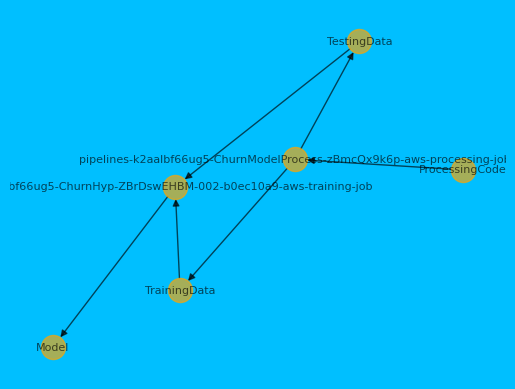

In [53]:
#visualize-lineage
plt.figure(3, figsize = (20, 14))
graph = nx.DiGraph()
graph.add_edges_from([(each[0], each[2]) for each in df1.values])
fig, ax = plt.subplots()
nx.draw_networkx(
    graph,
    node_size = 300,
    node_color = "orange",
    alpha = 0.65,
    font_size = 8,
    pos = nx.spring_layout(graph)
)
ax.set_facecolor('deepskyblue')
ax.axis('off')
fig.set_facecolor('deepskyblue')
plt.show()

### Task 2.27: Remove the pipeline

To delete the pipeline, run the following cell:

In [55]:
#delete-pipeline
response = sagemaker_client.delete_pipeline(PipelineName = 'ChurnModelSMPipeline')
print (response)

{'PipelineArn': 'arn:aws:sagemaker:us-west-2:281777908394:pipeline/ChurnModelSMPipeline', 'ResponseMetadata': {'RequestId': '49bec2d1-f87d-4762-a3af-ad62bc35ab2a', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '49bec2d1-f87d-4762-a3af-ad62bc35ab2a', 'content-type': 'application/x-amz-json-1.1', 'content-length': '88', 'date': 'Wed, 06 Nov 2024 15:54:38 GMT'}, 'RetryAttempts': 0}}


### Conclusion 

Congratulations! You have used Amazon SageMaker Pipelines to automate the creation and registry of a model. You learned how to drill down into each pipeline step to identify associated parameters, files, and logs. You know how to identify the assets that the pipeline used to generate the model, how to find the model in the model registry, and how to find and view the explainability and bias reports that a pipeline can generate.

### Cleanup

You have completed this notebook. To move to the next part of the lab, do the following:

- Close this notebook file.
- Return to the lab session and continue with the **Conclusion**.

### Hints and answers for task 2.16: Discover pipeline step details
General hint: **Step type** is found on the **Metadata** section in the **Details** tab.

1. For the step named **ChurnHyperParameterTuning**, locate the following details:
    - What is the **Step Type** for this step?</br>
    **Hint:** This information is found on the **Details** tab under the **Metadata** section.</br>
    **Answer:** Tuning</br>
    - What was the **Training Job** generated by this step? </br>
    **Hint:** This information is found on the **Overview** tab.</br>
    **Answer:** The model name is generated and will be different for each student. The name should be similar to this example: 056vhzs2vkxc-ChurnHy-TCAtUr16oV-001-17d5bd01
1. For the **ChurnEvalBestModel** step, locate the following details:
    - What is the **Step Type** for this step?
    **Answer:** Processing</br>
    - What is the name of the Python script that is used to evaluate the top model that was identified in the previous step?</br>
    **Hint:** This information is found on the **Settings** tab under the **Files** section.</br>
    **Answer:** evaluate.py</br>
    - Where is this file located?</br>
    **Hint:** This information is found on the **Settings** tab under the **Files** section.</br>
    **Answer:** The file resides in an S3 Bucket. The path is similar to this example: s3://sagemaker-us-west-2-1234567890/input/code/evaluate.py</br>
    - Where were the results from this step written?</br>
    **Hint:** This information is found on the **Settings** tab under the **Parameters** section, and then under **evaluation**.</br></br>
    **Answer:** The results of the evaluation were written to an S3 bucket. The path to the file should be similar to the following example: s3://sagemaker-us-west-2-1234567890/output/evaluation</br>
1. For the **CheckAUCScoreChurnEvaluation** step, locate the following details:
    - What is the **Step Type** for this step?</br>
    **Answer:** Condition</br>
    - What was the **Evaluation outcome**?</br>
    **Hint:** This information is found on the **Details** tab under the **Metadata** section.</br>
    **Answer:** True
1. For the **ChurnCreateModel** step, locate the following details:
    - What is the **Step Type** for this step?</br>
    **Answer:** Model</br>
    - Did this job generate any logs?</br>
    **Answer:** No
1. For the **RegisterChurnModel-RegisterModel** step, locate the following details:
    - What is the **Step Type** for this step?</br>
    **Answer:** RegisterModel</br>
1. For the **ChurnTransform** step, locate the following details:
    - What is the **Step Type** for this step?</br>
    **Answer:** Transform</br>
    - Did this job generate logs?</br>
    **Answer:** Yes</br>
    - Which files were inputs for this step?</br>
    **Hint:** This information is found on the **Settings** tab under the **Files** section. You might need to scroll to the bottom of the pane to find the file names.</br>
    **Answer:** model.tar.gz, sagemaker-xgboost:1.5-1-cpu-py3, batch.csv
1. For the **ChurnModelConfigFile** step, locate the following details: 
    - Which ProcessingInstanceType was used to run this job?</br>
    **Hint:** This information is found on the **Settings** tab.</br>
    **Answer:** ml.m5.xlarge
    - What is the **Step Type** for this step?</br>
    **Answer:** Processing
1. For the **ClarifyProcessingStep**, locate the following details:
    - What was the file output from this step?
    **Hint:** This information is found on the **Settings** tab under the **Files** section.</br>
    **Answer:** The output was bias data.
    - Where was the output written?
    **Answer:** The output was written to an S3 Bucket. The path should be similar to this example: s3://sagemaker-us-west-2-1234567890/clarify-output/bias